In [1]:
import tensorflow as tf
from tensorflow import keras




if tf.test.gpu_device_name()=='':
    print('You do not have GPU access.')
    !nvidia-smi

else:
  print('You have GPU access')
  !nvidia-smi


# print the tensorflow version
print('TensorFlow {}; Keras {}'.format(tf.__version__, keras.__version__))
tf.test.gpu_device_name()


C:\Users\Jens\miniconda3\envs\tensorflow\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


You have GPU access
Fri Oct 21 13:16:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.72       Driver Version: 512.72       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   63C    P0    17W /  N/A |    168MiB /  4096MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                    

'/device:GPU:0'

In [2]:
from tensorflow.keras import layers
import os
import tifffile as tiff
import numpy as np
from matplotlib import pyplot as plt
from keras.models import load_model
from preprocessing import get_model_memory_usage, unpatch_stack

#load pretrained model

model = load_model("models/bactunet_V4_3frame.hdf5", compile=False)

batch_size = 6
print("Model uses {} GB of memory at a batch size of {}".format(get_model_memory_usage(batch_size, model), batch_size))

Model uses 3.56 GB of memory at a batch size of 6


In [3]:
model.summary()
for l in model.weights:
    print(l.name, l.shape)

Model: "BactUnet_single_frame_training"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 288, 288) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 288, 288) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 288, 288) 1152        conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 64, 288, 288) 0           batch_normalization[0][0]        
_____________________________________________________________________

In [4]:
from preprocessing import patch_image, patch_stack, normalizePercentile, normalizeMinMax
from patchify import patchify

source_path = r"Bactnet/Training data/stacks/"
SIZE = 288




def prepare_data(source_path, PATCH_SIZE, validation=True):
    pred_dict = {}
    if validation:
        prefix = "validation"
    else:
        prefix = "training"
    stacks = os.listdir(os.path.join(source_path, prefix+"_source"))
    image_dataset = None
    mask_dataset = None
    for stack in stacks:
        if (stack.split(".")[-1]=="tif"):
            pred_dict[stack]={}
            img = tiff.imread(os.path.join(source_path, prefix+"_source",stack))
            pred_dict[stack]["image"]=img
            mask = tiff.imread(os.path.join(source_path, prefix+"_target", stack))
            pred_dict[stack]["y_true"]=mask
            print(stack, img.shape, mask.shape)
            
            img_patch = patch_stack(img, PATCH_SIZE)
            if len(mask.shape)==2:
                mask_patch = patch_image(mask, PATCH_SIZE)
            else:    
                mask_patch = patch_stack(mask, SIZE=PATCH_SIZE, DEPTH=1)
            
            print(stack, img_patch.shape, mask_patch.shape)
            mask_patch = normalizeMinMax(mask_patch)
            img_patch = normalizePercentile(img_patch, 0.1, 99.9, clip=True)
            pred_dict[stack]["image_patch"] = img_patch
            pred_dict[stack]["mask_patch"] = mask_patch


            #print(image_dataset.shape, mask_dataset.shape)

    return pred_dict

#pred_dict[file]=[image_stack, mask, patch, y_true, y_pred]
image_dict = prepare_data(source_path, SIZE, validation=True)
image_dict.update(prepare_data(source_path, SIZE, validation=False))
print(image_dict.keys())



BT0403_229.tif (13, 2304, 2304) (11, 2304, 2304)
BT0403_229.tif (704, 3, 288, 288) (704, 1, 288, 288)
BT0407_110.tif (7, 2304, 2304) (5, 2304, 2304)
BT0407_110.tif (320, 3, 288, 288) (320, 1, 288, 288)
BT0398_210.tif (13, 2304, 2304) (11, 2304, 2304)
BT0398_210.tif (704, 3, 288, 288) (704, 1, 288, 288)
BT402_169.tif (5, 2304, 2304) (3, 2304, 2304)
BT402_169.tif (192, 3, 288, 288) (192, 1, 288, 288)
BT403_002.tif (13, 2304, 2304) (11, 2304, 2304)
BT403_002.tif (704, 3, 288, 288) (704, 1, 288, 288)
BT404_199.tif (5, 2304, 2304) (3, 2304, 2304)
BT404_199.tif (192, 3, 288, 288) (192, 1, 288, 288)
dict_keys(['BT0403_229.tif', 'BT0407_110.tif', 'BT0398_210.tif', 'BT402_169.tif', 'BT403_002.tif', 'BT404_199.tif'])


In [5]:
keras.backend.clear_session()
stride = 2

# #IOU
for stack in image_dict.keys():
    y_pred = None
    img_stack = image_dict[stack]
    for i in range(0, len(img_stack["image_patch"]), stride):
        pred = model.predict(img_stack["image_patch"][i:i+stride])
        if y_pred is not None:
            y_pred = np.concatenate((y_pred, pred))

        if y_pred is None:
            y_pred = pred
    
    image_dict[stack]["y_pred"] = unpatch_stack(y_pred, 8, 8, 1)
    print(stack, y_pred.shape, image_dict[stack]["y_pred"].shape)
    

BT0403_229.tif (704, 1, 288, 288) (11, 1, 2304, 2304)
BT0407_110.tif (320, 1, 288, 288) (5, 1, 2304, 2304)
BT0398_210.tif (704, 1, 288, 288) (11, 1, 2304, 2304)
BT402_169.tif (192, 1, 288, 288) (3, 1, 2304, 2304)
BT403_002.tif (704, 1, 288, 288) (11, 1, 2304, 2304)
BT404_199.tif (192, 1, 288, 288) (3, 1, 2304, 2304)


In [6]:
for stack in image_dict.keys():
    saveme = np.concatenate(((image_dict[stack]["y_pred"]>0.5)*255, np.expand_dims(image_dict[stack]["y_true"],axis=1)), axis=1)
    saveme = saveme.astype('uint8')
    prefix="V4_3frame"
    dic = unpatch_stack(image_dict[stack]["image_patch"], 8, 8, 3)
    dic = dic[:,1,:,:] * 255
    dic = np.expand_dims(dic, axis=1).astype('uint8')
    print(dic.shape, image_dict[stack]["image_patch"].max())
    saveme = np.concatenate((dic, saveme), axis=1)
    tiff.imwrite(os.path.join(r"C:\Users\Jens\Documents\Code\BactUnet\Bactnet\Training data\stacks\predict", prefix+stack), saveme, imagej=True,
                      metadata={'unit': 'um', 'finterval': 15,
                                'axes': 'TCYX'})

(11, 1, 2304, 2304) 1.0
(5, 1, 2304, 2304) 1.0
(11, 1, 2304, 2304) 1.0
(3, 1, 2304, 2304) 1.0
(11, 1, 2304, 2304) 1.0
(3, 1, 2304, 2304) 1.0


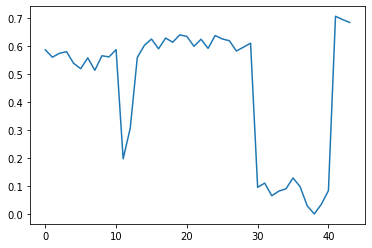

In [8]:
y_tru = None
y_pre = None

for stack in image_dict.keys():
    if y_tru is None:
        y_tru = image_dict[stack]["y_true"]
        y_pre = image_dict[stack]["y_pred"]
    else:
        y_tru = np.concatenate((y_tru, image_dict[stack]["y_true"]))
        y_pre = np.concatenate((y_pre, image_dict[stack]["y_pred"]))
        
dices = []
IOUs = []
frames = []
threshold = 0.5

y_pred_thresholded = (y_pre > threshold) * 255
y_pred_thresholded = y_pred_thresholded.astype('uint8')

for i in range(len(y_tru)):
    intersection = np.logical_and(y_tru[i], y_pred_thresholded[i])
    union = np.logical_or(y_tru[i], y_pred_thresholded[i])
    iou_score = np.sum(intersection) / np.sum(union)
    IOUs.append(iou_score)

frames =  list(range(len(y_tru)))

    
#plt.plot(frames, dices)
plt.plot(frames, IOUs)
plt.show()


In [9]:
def dice_score(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3) # for easy reading
    return dice    

def iou_score(mask1, mask2):
    intersection = np.logical_and(mask1, mask1)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)
    

for stack in image_dict.keys():
    image_dict[stack]
    image_dict[stack]['y_pred']


In [10]:
from preprocessing import pad_stack, crop_stack, predict_stack


def crop_stack(arr, SIZE):
    """
    Undoes the padding from pad_stack, crops out the center, removing a 1/2 SIZE broder from around the stack
    """
    pad_SIZE = int(SIZE / 2)

    if len(arr.shape) == 3:
        t, y, x = arr.shape
        stopY = y - pad_SIZE
        stopX = x - pad_SIZE
        return arr[:, pad_SIZE:stopY, pad_SIZE:stopX]

    if len(arr.shape) == 4:
        t, c, y, x = arr.shape
        stopY = y - pad_SIZE
        stopX = x - pad_SIZE
        return arr[:, :, pad_SIZE:stopY, pad_SIZE:stopX]

#Lets enlarge and see if patch edge regions are affecting the results

source_path = r"Bactnet/Training data/stacks/validation_source"
stacks = os.listdir(os.path.join(source_path))
        

ypred_2 = None
    
for i, image_name in enumerate(stacks):  # Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'tif'):
        image = tiff.imread(os.path.join(source_path, image_name))
        image = normalizePercentile(image, 0.1, 99.9, clip=True)
        expanded_image = pad_stack(image, SIZE)
        expanded_patch = patch_stack(expanded_image, SIZE)
        pred = predict_stack(expanded_patch, 2, model)
        pred = unpatch_stack(pred, 9, 9, 1)
        pred = crop_stack(pred, SIZE)
        if ypred_2 is None:
            ypred_2 = pred 
        else:
            ypred_2 = np.concatenate((ypred_2, pred))

        print(image_name, expanded_image.shape, pred.shape, ypred_2.shape)







Prediction frames: 0-2 of 891
Prediction frames: 2-4 of 891
Prediction frames: 4-6 of 891
Prediction frames: 6-8 of 891
Prediction frames: 8-10 of 891
Prediction frames: 10-12 of 891
Prediction frames: 12-14 of 891
Prediction frames: 14-16 of 891
Prediction frames: 16-18 of 891
Prediction frames: 18-20 of 891
Prediction frames: 20-22 of 891
Prediction frames: 22-24 of 891
Prediction frames: 24-26 of 891
Prediction frames: 26-28 of 891
Prediction frames: 28-30 of 891
Prediction frames: 30-32 of 891
Prediction frames: 32-34 of 891
Prediction frames: 34-36 of 891
Prediction frames: 36-38 of 891
Prediction frames: 38-40 of 891
Prediction frames: 40-42 of 891
Prediction frames: 42-44 of 891
Prediction frames: 44-46 of 891
Prediction frames: 46-48 of 891
Prediction frames: 48-50 of 891
Prediction frames: 50-52 of 891
Prediction frames: 52-54 of 891
Prediction frames: 54-56 of 891
Prediction frames: 56-58 of 891
Prediction frames: 58-60 of 891
Prediction frames: 60-62 of 891
Prediction frames

Prediction frames: 490-492 of 891
Prediction frames: 492-494 of 891
Prediction frames: 494-496 of 891
Prediction frames: 496-498 of 891
Prediction frames: 498-500 of 891
Prediction frames: 500-502 of 891
Prediction frames: 502-504 of 891
Prediction frames: 504-506 of 891
Prediction frames: 506-508 of 891
Prediction frames: 508-510 of 891
Prediction frames: 510-512 of 891
Prediction frames: 512-514 of 891
Prediction frames: 514-516 of 891
Prediction frames: 516-518 of 891
Prediction frames: 518-520 of 891
Prediction frames: 520-522 of 891
Prediction frames: 522-524 of 891
Prediction frames: 524-526 of 891
Prediction frames: 526-528 of 891
Prediction frames: 528-530 of 891
Prediction frames: 530-532 of 891
Prediction frames: 532-534 of 891
Prediction frames: 534-536 of 891
Prediction frames: 536-538 of 891
Prediction frames: 538-540 of 891
Prediction frames: 540-542 of 891
Prediction frames: 542-544 of 891
Prediction frames: 544-546 of 891
Prediction frames: 546-548 of 891
Prediction fra

Prediction frames: 82-84 of 405
Prediction frames: 84-86 of 405
Prediction frames: 86-88 of 405
Prediction frames: 88-90 of 405
Prediction frames: 90-92 of 405
Prediction frames: 92-94 of 405
Prediction frames: 94-96 of 405
Prediction frames: 96-98 of 405
Prediction frames: 98-100 of 405
Prediction frames: 100-102 of 405
Prediction frames: 102-104 of 405
Prediction frames: 104-106 of 405
Prediction frames: 106-108 of 405
Prediction frames: 108-110 of 405
Prediction frames: 110-112 of 405
Prediction frames: 112-114 of 405
Prediction frames: 114-116 of 405
Prediction frames: 116-118 of 405
Prediction frames: 118-120 of 405
Prediction frames: 120-122 of 405
Prediction frames: 122-124 of 405
Prediction frames: 124-126 of 405
Prediction frames: 126-128 of 405
Prediction frames: 128-130 of 405
Prediction frames: 130-132 of 405
Prediction frames: 132-134 of 405
Prediction frames: 134-136 of 405
Prediction frames: 136-138 of 405
Prediction frames: 138-140 of 405
Prediction frames: 140-142 of 4

In [11]:
print(y_tru.shape, y_pre.shape, ypred_2.shape)


(44, 2304, 2304) (44, 1, 2304, 2304) (16, 1, 2304, 2304)


In [45]:
#length of each dataset
l_BT0398_210 = 11
l_BT402_168 = 3
l_BT403_000 = 11
l_BT403_228 = 11
l_BT404_199 = 1

In [24]:

image_dataset = unpatch_stack(image_dataset[:,1,:,:], 8, 8, 1)

In [25]:
print(image_dataset.shape, y_pre.shape, y_tru.shape)
saveme = np.concatenate((image_dataset, y_tru, y_pre, ypred_2), axis=1)
saveme = saveme * 65535
saveme = saveme.astype('uint16')
print(saveme.shape)

(37, 1, 2304, 2304) (37, 1, 2304, 2304) (37, 1, 2304, 2304)
(37, 4, 2304, 2304)


In [26]:
results_folder = r"_results"
tiff.imwrite(os.path.join(results_folder, "all_masked_stacks_V3b.tif"), saveme, imagej=True, resolution=(1./2.6755, 1./2.6755),
                      metadata={'unit': 'um', 'finterval': 15,
                                'axes': 'TCYX'})

In [49]:
#Viktors data
source_path = r"Bactnet/viktor"
stacks = os.listdir(os.path.join(source_path))
print(stacks)
vikt = None

def predict_stack(arr, batch_size, model):
    """
    Performs prediction on all images in arr using model in increments of batch_size
    Assumes patches of a ahpe where N is 0th axis.
    """
    keras.backend.clear_session()
    y_pred = None
    for i in range(0, len(arr), batch_size):
        subset = arr[i:i + batch_size]
        
        pred = model.predict(subset)
        if y_pred is not None:
            y_pred = np.concatenate((y_pred, pred))

        else:
            y_pred = pred

    return y_pred

for i, image_name in enumerate(stacks):  # Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[-1] == 'tif'):
        image = tiff.imread(os.path.join(source_path, image_name))
        image = image[0:100]
        image = normalizePercentile(image, 0.1, 99.9, clip=True)
        patch = patch_stack(image, SIZE)
        print(image.shape, patch.shape)
        pred = predict_stack(patch, 2, model)
        pred = unpatch_stack(pred, 8, 8, 1)
        
        if vikt is None:
            vikt = pred 
        else:
            vikt = np.concatenate((vikt, pred))
        



['210218_murine-ML-hydrogel_60k-cells_A_2_inf_1_MMStack_Default.ome.tif']
(100, 2304, 2304) (6272, 3, 288, 288)


In [62]:
saveme = vikt * 65535
saveme = saveme.astype('uint16')
img = np.expand_dims(image[0:-2], axis = 1)
img = img * 65535
img = img.astype('uint16')
print(saveme.shape, img.shape)
saveme = np.concatenate((img,saveme), axis = 1)
print(saveme.shape)
tiff.imwrite(os.path.join(source_path, "pred.tif"), saveme, imagej=True, resolution=(1./0.109, 1./0.109),
                      metadata={'unit': 'um', 'finterval': 15,
                                'axes': 'TCYX'})



(98, 1, 2304, 2304) (98, 1, 2304, 2304)
(98, 2, 2304, 2304)


In [15]:


#load unseen data

validation_image_directory = r"C:\Users\analyst\Documents\Python Scripts\BactUnet\Bactnet\Training data\stacks\predict"
result_folder = r"C:\Users\analyst\Documents\Python Scripts\BactUnet\_results"

val_image_dataset = []
val_mask_dataset = []
pred_mask_dataset = []

images = os.listdir(validation_image_directory)

for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'tif'):
        
        image = tiff.imread(os.path.join(validation_image_directory, image_name))
        original_shape = image.shape
        patch = patch_stack(image, SIZE)
        
        patch = normalizePercentile(patch, 0.1, 99.9, clip=True)
        pred_mask_patch = model.predict(patch)
        print(image_name, original_shape, patch.shape, pred_mask_patch.shape)
        #pred_mask_patch = pred_mask_patch[:, 0, :,:]
        image = np.expand_dims(patch[:, 1, :,:], axis=1)
        patch = np.concatenate((image, pred_mask_patch), axis=1)
        unpatched = unpatcher(patch, 8, 8, 2)
        print(patch.shape)
        tiff.imwrite(os.path.join(result_folder, image_name), unpatched, imagej=True, resolution=(1./2.6755, 1./2.6755),
                      metadata={'unit': 'um', 'finterval': 15,
                                'axes': 'TCYX'})
        
        #pred_mask = unpatch_stack(pred_mask_patch, original_shape)
        #tiff.imsave(os.path.join(result_folder, image_name), pred_mask_patch)
        #val_image_dataset.append(image)
        #pred_mask_dataset.append(pred_mask)

BT0398_210.tif (11, 2304, 2304) (576, 3, 288, 288) (576, 1, 288, 288)
(576, 2, 288, 288)
BT403_013.tif (12, 2304, 2304) (640, 3, 288, 288) (640, 1, 288, 288)
(640, 2, 288, 288)
BT403_216.tif (12, 2304, 2304) (640, 3, 288, 288) (640, 1, 288, 288)
(640, 2, 288, 288)
BT404_001.tif (12, 2304, 2304) (640, 3, 288, 288) (640, 1, 288, 288)
(640, 2, 288, 288)


In [34]:
for i in range(len(pred_mask_dataset)):
    img = val_image_dataset[i][3]
    msk = pred_mask_dataset[i][3]
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    plt.title('Testing Image')
    plt.imshow(img)
    plt.subplot(122)
    plt.title('Prediction on test image')
    plt.imshow(msk)
    plt.show()

1 conv2d (3, 3, 3, 64)
4 conv2d_1 (3, 3, 64, 64)
8 conv2d_2 (3, 3, 64, 128)
11 conv2d_3 (3, 3, 128, 128)
15 conv2d_4 (3, 3, 128, 256)
18 conv2d_5 (3, 3, 256, 256)
22 conv2d_6 (3, 3, 256, 512)
25 conv2d_7 (3, 3, 512, 512)
29 conv2d_8 (3, 3, 512, 1024)
32 conv2d_9 (3, 3, 1024, 1024)
35 conv2d_transpose (2, 2, 512, 1024)
37 conv2d_10 (3, 3, 1024, 512)
40 conv2d_11 (3, 3, 512, 512)
43 conv2d_transpose_1 (2, 2, 256, 512)
45 conv2d_12 (3, 3, 512, 256)
48 conv2d_13 (3, 3, 256, 256)
51 conv2d_transpose_2 (2, 2, 128, 256)
53 conv2d_14 (3, 3, 256, 128)
56 conv2d_15 (3, 3, 128, 128)
59 conv2d_transpose_3 (2, 2, 64, 128)
61 conv2d_16 (3, 3, 128, 64)
64 conv2d_17 (3, 3, 64, 64)
67 conv2d_18 (1, 1, 64, 1)


IndexError: index 3 is out of bounds for axis 2 with size 3

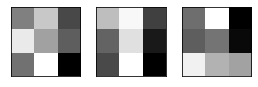

In [51]:
all_weights = []

for i, layer in enumerate(model.layers):
  if "onv" in layer.name:
    all_weights.append
    print(i, layer.name, model.layers[i].get_weights()[0].shape)

weights, biases =  model.layers[1].get_weights()
fig1=plt.figure(figsize=(12, 12))


columns = 8 
rows = 8 
n_filters = columns*rows
for i in range(1, n_filters +1):
    f = weights[:, :, (i-1), 0]
    fig1 =plt.subplot(rows, columns, i)
    fig1.set_xticks([])  #Turn off axis
    fig1.set_yticks([])

    #plt.imshow(f[i%3, :, :], cmap='gray')
    plt.imshow(f[:, :], cmap='gray')
    #plt.imshow(f[2, :, :], cmap='gray') #Show only the filters from 0th channel (R)
    #ix += 1
plt.show() 